# Project: HOT OR NOT 
The aim of this project is to analyse the sentiments of tweets posted on Twitter using the Climate Change Data Set put together by
Dimitrios Effrosynidis et al. We linked the twitter dataset to disaster events as declared by FEMA for the United States during the period 2011-19. The resultant dataset is being analysed in this Python Notebook. 

In [1]:
# Code contribution - Ridhi Purohit
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model 
import itertools
import statsmodels.api as sm
from scipy import stats

df = pd.read_csv("/home/ridhi/30122-project-hot-or-not/main/sources/merged_date_county.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   disasterNumber     3321 non-null   int64  
 1   state              3321 non-null   object 
 2   declarationType    3321 non-null   object 
 3   declarationDate    3321 non-null   object 
 4   incidentBeginDate  3321 non-null   object 
 5   incidentEndDate    3321 non-null   object 
 6   fyDeclared         3321 non-null   int64  
 7   incidentType       3321 non-null   object 
 8   declarationTitle   3321 non-null   object 
 9   fipsStateCode      3321 non-null   int64  
 10  fipsCountyCode     3321 non-null   int64  
 11  date               3321 non-null   object 
 12  county_FIP         3321 non-null   int64  
 13  topic              3321 non-null   object 
 14  stance             3321 non-null   object 
 15  gender             3321 non-null   object 
 16  aggressiveness     3321 

Since, the merged data set contained categorical columns of interest, so they were encoded into numerical categories for easier analysis.
The catgorical encoding is done in such a way that the class index of the category refers to the integer category assigned to it as displayed below. Please note that the tweet sentiments were averaged to create this data set with multiple tweet IDs being associated with each unique set of data points.

In [2]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
df['stance_cat'] = encoder.fit_transform(df['stance'])
print(encoder.classes_)

df['declarationType_cat'] = encoder.fit_transform(df['declarationType'])
print(encoder.classes_)

df['incidentType_cat'] = encoder.fit_transform(df['incidentType'])
print(encoder.classes_)

df['topic_cat'] = encoder.fit_transform(df['topic'])
print(encoder.classes_)

df['gender_cat'] = encoder.fit_transform(df['gender'])
print(encoder.classes_)

df['aggressiveness_cat'] = encoder.fit_transform(df['aggressiveness'])
print(encoder.classes_)

['believer' 'denier' 'neutral']
['DR' 'FM']
['Fire' 'Severe Storm' 'Snowstorm']
['Donald Trump versus Science' 'Global stance'
 'Ideological Positions on Global Warming'
 'Impact of Resource Overconsumption' 'Importance of Human Intervantion'
 'Politics' 'Seriousness of Gas Emissions'
 'Significance of Pollution Awareness Events'
 'Undefined / One Word Hashtags' 'Weather Extremes']
['female' 'male' 'undefined']
['aggressive' 'not aggressive']


Upon analysis of the data, it was discovered that the column "declarationTitle" contained some duplicate titles. The following piece
of code was written to remove those redundancies so that the events could be clearly identified with their names that can be tranferred to the data visulaization component later. 

In [3]:
disaster_temp = []
for ele in df.itertuples(index=False):
    disaster_temp.append((ele.declarationTitle, ele.declarationDate, ele.incidentBeginDate, ele.incidentEndDate))

#identify unique disasters
disasters_dates =  list(set(disaster_temp))

#identify duplicate disaster event names
duplist = []
tot_items = []
for dis,_,_,_ in disasters_dates:
   if dis not in tot_items:
        tot_items.append(dis)
   else:
        duplist.append(dis)

dupes = []
for ele in disasters_dates:
     if ele[0] in duplist:
          dupes.append(ele)

unique_ele = {}
list_without_recurring = []

for lst in dupes:
    if lst[0] not in unique_ele:
        unique_ele[lst[0]] = True
        list_without_recurring.append(lst)
    else:
        pass

#update unique disaster event names
for index, row in df.iterrows():
    for ele, d1, d2, d3 in list_without_recurring:
        if row['declarationTitle'] == ele and row['declarationDate'] == d1 and row['incidentBeginDate'] == d2 and row['incidentEndDate'] == d3:
          df.at[index, 'declarationTitle'] += '2'

for ele in df.itertuples(index=False):
    disaster_temp.append((ele.declarationTitle, ele.declarationDate, ele.incidentBeginDate, ele.incidentEndDate))

#identify unique disasters
disasters_dates =  list(set(disaster_temp))

The first analysis consisted of segmenting the data to analyse the average tweet sentiment before and after an extreme weather event was
declared a disaster by FEMA. Using the average sentiments, percentage changes are computed to indicate the change in average sentiment before and after the cut-off set by the "declarationDate". Further, Sentiment_Change is used to indicate whether the average sentiment transitioned towards positive or negative post the disaster declaration. 

In [4]:
df2 = pd.DataFrame(disasters_dates, columns= ['declarationTitle', 'declarationDate', 'incidentBeginDate','incidentEndDate'])

#identify tweets before and after disaster was declared
df['before_disaster'] = 0
for i in df.index:
    if df['date'][i] >= df['incidentBeginDate'][i] and df['date'][i] <= df['declarationDate'][i]:
        df['before_disaster'][i] = 1

#finidng average sentiments before and after disaster event declaration
df3 = pd.DataFrame({'Avg_Sentiment': df.groupby(['declarationTitle','before_disaster'])['sentiment'].mean()}).reset_index()

temp = df3[df3['before_disaster'] == 1]
df2 = pd.merge(df2, temp, on = 'declarationTitle')
df2 = df2.rename(columns={"Avg_Sentiment": "Avg_Sentiment_Before"})
df2 = df2.drop(['before_disaster'],axis = 1)

temp = df3[df3['before_disaster'] == 0]
df2 = pd.merge(df2, temp, on = 'declarationTitle')
df2 = df2.rename(columns={"Avg_Sentiment": "Avg_Sentiment_After"})
df2 = df2.drop(['before_disaster'],axis = 1)

#changes in sentiments before and after disaster event declaartion
df2['Avg_Sentiment_Pct_Chng'] = ((df2['Avg_Sentiment_Before'] - df2['Avg_Sentiment_After']) / df2['Avg_Sentiment_Before']) * 100

df2['Sentiment_Change'] = df2.apply(lambda row: 'positive' if row['Avg_Sentiment_After'] > row['Avg_Sentiment_Before'] else 'negative', axis=1)

avg_pct_chg = round(df2['Avg_Sentiment_Pct_Chng'].mean())
print(f'\n On averge, the tweet sentiments changed by {avg_pct_chg}%. \n')

print(df2.head())
df2.to_csv('average_sentiments_data.csv')


 On averge, the tweet sentiments changed by 28%. 

  declarationTitle declarationDate incidentBeginDate incidentEndDate  \
0   GUN RANGE FIRE      2019-08-30        2019-08-30      2019-08-31   
1     FREEDOM FIRE      2012-08-03        2012-08-03      2012-08-12   
2   ROOSEVELT FIRE      2018-09-18        2018-09-18      2018-10-06   
3     SHOCKEY FIRE      2012-09-24        2012-09-23      2012-09-27   
4      HANSEL FIRE      2014-08-06        2014-08-05      2014-08-14   

   Avg_Sentiment_Before  Avg_Sentiment_After  Avg_Sentiment_Pct_Chng  \
0             -0.180251            -0.006228               96.544770   
1              0.046468            -0.046566              200.210512   
2              0.052591             0.037409               28.868721   
3             -0.577115             0.280050              148.525833   
4              0.105476            -0.149158              241.414249   

  Sentiment_Change  
0         positive  
1         negative  
2         negative 

/tmp/user/23098/ipykernel_2881113/3773399906.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['before_disaster'][i] = 1


Visualizing the results of average tweet sentiments before and after the disaster event results in a better understanding of the sentiment
variation in the data. It appears that on average people's sentiments regarding climate change did not drastically change after they experienced a disaster event. This analysis did not distinguish between climate change believers and deniers which indicates that whether people believe or deny climate change doesn't impact the connotations with which they speak about it. Being a climate change believer, doesn't necessarily mean the sentiments of your tweet would not be negative. This has policy implications for the way we communicate about an important issue like climate change which can be further studied to design messaging that is effective in communicating the 
impact of climate change on our lives.

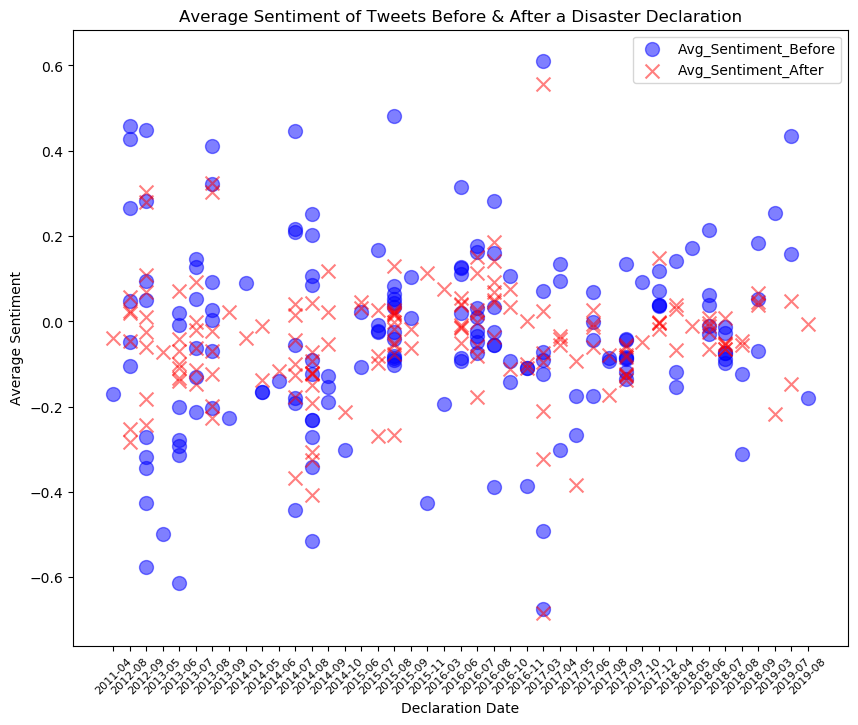

In [27]:
cols = ['declarationTitle', 'declarationDate','Avg_Sentiment_Before', 'Avg_Sentiment_After']
df_plt = df2.loc[:, cols]
df_plt = df_plt.sort_values(by="declarationDate", ascending=True)
df_plt['Year_Month'] = df_plt['declarationDate'].apply(lambda x: x[:7])

fig, ax = plt.subplots(figsize=(10, 8))

markers = {'Avg_Sentiment_Before': 'o', 'Avg_Sentiment_After': 'x'}
colors = {'Avg_Sentiment_Before': 'blue', 'Avg_Sentiment_After': 'red'}

# Plot the data for average tweet sentiments before and after the disaster event
for val in ['Avg_Sentiment_Before', 'Avg_Sentiment_After']:
    ax.scatter(df_plt['Year_Month'], df_plt[val], marker=markers[val], color=colors[val], alpha=0.5, s=100,label=f'{val}')
plt.xticks(fontsize=8, rotation=45)
plt.gca().set(title="Average Sentiment of Tweets Before & After a Disaster Declaration", xlabel="Declaration Date", ylabel="Average Sentiment")

ax.legend()
plt.show()


 The second analysis consisted of a regression to predict the stance on climate change. It involved regressing the type of disaster event, gender and average sentiment to predict whether someone is a climate change believer or denier.

In [29]:
X_train = df[['incidentType_cat', 'gender_cat', 'sentiment']]
y_train = df['stance_cat']

# Add intercept term to X
X = sm.add_constant(X_train)

# Fit OLS regression model
model = sm.OLS(y_train, X).fit(cov_type = "HC0")

# Print summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             stance_cat   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     52.57
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           3.45e-33
Time:                        11:45:16   Log-Likelihood:                -3951.2
No. Observations:                3321   AIC:                             7910.
Df Residuals:                    3317   BIC:                             7935.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4939      0.037  

The *regression indicates that sentiment is not statistically significant when it comes to predicting someone's stance on climate change. This is in alignment with the results from the previous analysis, i.e. being a climate change believer or denier doesn't impact if you speak negatively or positively about the issue. We observe that gender has a statistically significant impact on stance. This result seems to confirm the results of the Holmberg and Hellsten (2015) study which reported that female tweeters show a more convinced attitude towards climate change as referenced in the original study. Please note that we do not make any claims about the gender reported in the climate change twitter data set as it is predicted using alogirthms. Though the gender prediction is reported as being highly accurate, we do not interpret it as being accurate per the actual people who are assicated with the tweets. 
Lastly, it is observed that the incident type is statistically significant when trying to predict stance. However, we cannot establish whether it is causal or what relationships exists between incident type and stance based on this limited analysis.

*Please note that the regression analysis results are interpreted as descriptive and not causal. We do not make any claims about the causality of the observations in data. 

The third analysis was done to observe the frequency of tweets before and after a disaster for climate change deniers and believers separately. The goal was to check if there was an increase in frequency of tweets for believers or deniers after a disaster event.
On visualising the analysis, we observe that indeed there was an uptick in the frequency of tweets after a disaster event for both deniers and believers. However, since the data analysis is done on a limited set of data from the original dataset, much more sophisticated analysis is required to understand causality than the scope of this project allowed.

In [30]:
#believer 0, denier 1
df4 = pd.DataFrame(disasters_dates, columns= ['declarationTitle', 'declarationDate', 'incidentBeginDate','incidentEndDate'])
df4 = df4.drop(['incidentBeginDate','incidentEndDate'],axis = 1)

temp = df[df['stance_cat'] == 0]
df5 = pd.DataFrame({'Frequency': temp.groupby(['declarationTitle','stance', 'before_disaster'])['stance_cat'].count()}).reset_index()
df5 = pd.merge(df4, df5, on = 'declarationTitle')
df5 = df5.rename(columns={"Frequency": "Frequency_Before", "stance": "Stance_Before"})

temp = df[df['stance_cat'] == 1]
df6 = pd.DataFrame({'Frequency': temp.groupby(['declarationTitle','stance', 'before_disaster'])['stance_cat'].count()}).reset_index()
df6 = pd.merge(df4, df6, on = 'declarationTitle')
df6 = df6.rename(columns={"Frequency": "Frequency_After", "stance": "Stance_After"})

       declarationTitle declarationDate Stance_Before  before_disaster  \
0           HELENA FIRE      2017-09-01      believer                0   
1           CLOVER FIRE      2013-09-10      believer                0   
2           CLOVER FIRE      2013-09-10      believer                1   
3             YALE FIRE      2016-08-22      believer                0   
4             YALE FIRE      2016-08-22      believer                1   
..                  ...             ...           ...              ...   
353        ERSKINE FIRE      2016-06-24      believer                1   
354  MILLI 0843 CS FIRE      2017-08-17      believer                0   
355           WEST FIRE      2018-07-06      believer                0   
356           WEST FIRE      2018-07-06      believer                1   
357   YARNELL HILL FIRE      2013-06-30      believer                0   

     Frequency_Before  
0                  13  
1                   1  
2                   1  
3              

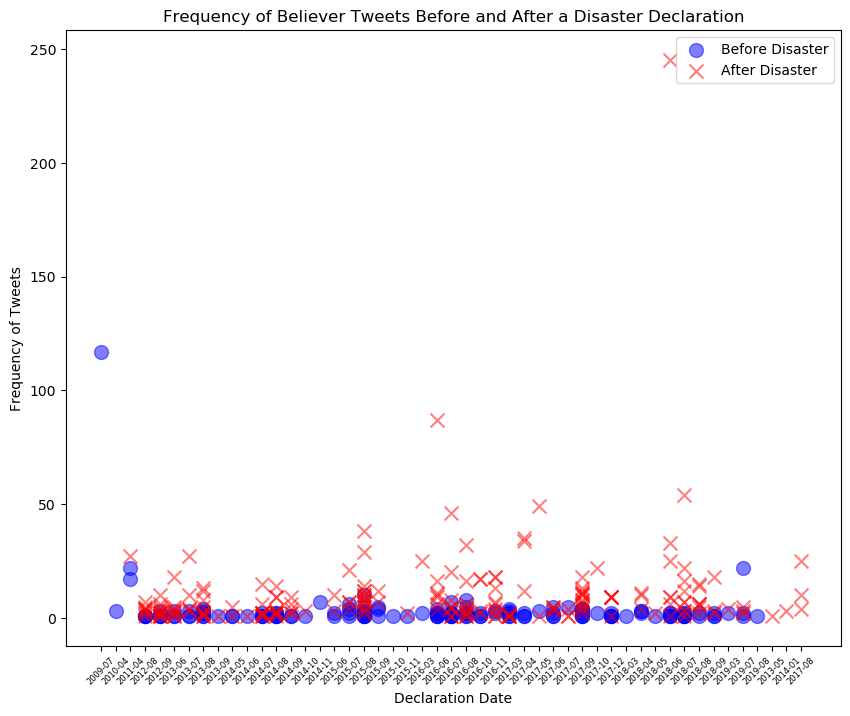

In [31]:
cols = ['declarationDate', 'Frequency_Before', 'before_disaster']
df7 = df5.loc[:, cols]
df7 = df7.sort_values(by="declarationDate", ascending=True)
df7.loc[df7['before_disaster'] == 0, 'before_disaster'] = 'After Disaster'
df7.loc[df7['before_disaster'] == 1, 'before_disaster'] = 'Before Disaster'

df7['Year_Month'] = df7['declarationDate'].apply(lambda x: x[:7])

fig, ax = plt.subplots(figsize=(10, 8))

markers = {'After Disaster': 'x', 'Before Disaster': 'o'}
colors = {'After Disaster': 'red', 'Before Disaster': 'blue'}

# Plot the data for believer tweet frequency before and after the disaster event
for val in df7['before_disaster'].unique():
    subset = df7[df7['before_disaster'] == val]
    ax.scatter(subset['Year_Month'], subset['Frequency_Before'], marker=markers[val], color=colors[val], alpha=0.5, s=100,label=f'{val}')

plt.xticks(fontsize=6, rotation=45)
plt.gca().set(title="Frequency of Believer Tweets Before and After a Disaster Declaration", xlabel="Declaration Date", ylabel="Frequency of Tweets")

ax.legend()
plt.show()

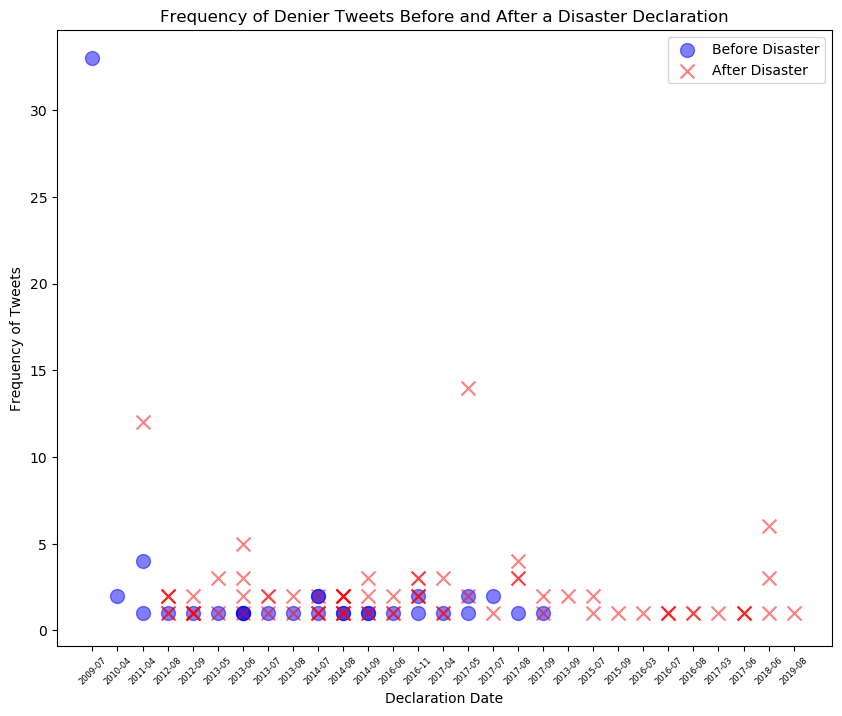

In [32]:
cols = ['declarationDate', 'Frequency_After', 'before_disaster']
df8 = df6.loc[:, cols]
df8 = df8.sort_values(by="declarationDate", ascending=True)
df8.loc[df8['before_disaster'] == 0, 'before_disaster'] = 'After Disaster'
df8.loc[df8['before_disaster'] == 1, 'before_disaster'] = 'Before Disaster'

df8['Year_Month'] = df8['declarationDate'].apply(lambda x: x[:7])

fig, ax = plt.subplots(figsize=(10, 8))

markers = {'After Disaster': 'x', 'Before Disaster': 'o'}
colors = {'After Disaster': 'red', 'Before Disaster': 'blue'}

# Plot the data for denier tweet frequency before and after the disaster event
for val in df8['before_disaster'].unique():
    subset = df8[df8['before_disaster'] == val]
    ax.scatter(subset['Year_Month'], subset['Frequency_After'], marker=markers[val], color=colors[val], alpha=0.5, s=100,label=f'{val}')

plt.xticks(fontsize=6, rotation=45)
plt.gca().set(title="Frequency of Denier Tweets Before and After a Disaster Declaration", xlabel="Declaration Date", ylabel="Frequency of Tweets")

ax.legend()
plt.show()

### Conclusion
Our analysis leads us to the conclusion that people's sentiment towards climate change are not related to them being a climate change believer or denier. From a very poor fit of the regression, we infer that predicting people's stance on climate change requires more factors than we had hypothesised. We observed that people's sentiment did not have a significant impact on their stance but disaster event and gender did. Lastly, frequency of tweets regarding climate change before and after a disaster event increases for both believers and deniers. These are some preeliminary findings from the data which can be further studied to inform policy decisions. An important policy implication is that the objectivity with which you communicate about climate change could impact people's perceptions
while also taking into account that a direct connect needs to be established between climate change and disaster events by policymakers. Thus, it is extremely important to understand how to effectively communicate about a sensitive and polarising issue like climate change.